In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
sys.path.insert(0, os.path.abspath('../palin/python'))

In [ ]:
#from palin.simulation import Experiment
from palin.simulation.experiment import Experiment
from palin.simulation.analyser import Analyser
from palin.simulation.experiments.simple_experiment import SimpleExperiment
from palin.simulation.experiments.double_pass_experiment import DoublePassExperiment
from palin.simulation.trial import Int2Trial, Int1Trial 
from palin.simulation.observers.linear_observer import LinearObserver
from palin.simulation.analysers.kernel_distance import KernelDistance
from palin.simulation.analysers.internal_noise_value import InternalNoiseValue
from palin.kernels.classification_images import ClassificationImage 
from palin.kernels.glm_kernel import GLMKernel
from palin.internal_noise.double_pass import DoublePass

from palin.internal_noise.intercept_method import InterceptMethod
from palin.simulation.simulation import Simulation as Sim

In [17]:
from palin.internal_noise.glm_method import GLMMethod

generate simulated responses from a simple observer with noise

In [309]:
observed_noise_std=1.1
n_trials = 150
exp = DoublePassExperiment(n_trials = n_trials,n_repeated=n_trials, 
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = observed_noise_std, 
                                        criteria = 0)
responses = obs.respond_to_experiment(exp)
responses_df = Analyser.to_df(exp, responses)
responses_df

,trial,stim,feature,value,response
0,0,0,0,-48.706496,True
1,0,0,1,20.833937,True
2,0,0,2,-8.022884,True
3,0,0,3,32.840460,True
4,0,0,4,39.567654,True
...,...,...,...,...,...
3595,299,1,1,-20.861168,True
3596,299,1,2,-82.528085,True
3597,299,1,3,108.384172,True
3598,299,1,4,151.647533,True


## Extract kernel

In [310]:
kernel_df, results = GLMKernel.extract_single_kernel(data_df=responses_df, feature_id='feature', value_id='value', response_id='response')
kernel_df=kernel_df.reset_index()
kernel_df['kernel_value'].values

array([-0.00169427,  0.01010364, -0.01636297, -0.00050427,  0.00663745,
        0.01366558])

## CI internal noise

In [311]:
ci_df = GLMKernel.get_confidence_intervals(results)
ci_df=ci_df.reset_index()
ci_df

,index,lower_bound,upper_bound
0,diff_value0,-0.004256,0.000868
1,diff_value1,0.006965,0.013242
2,diff_value2,-0.020486,-0.012240
3,diff_value3,-0.003286,0.002277
4,diff_value4,0.003967,0.009308
5,diff_value5,0.009822,0.017510


In [316]:
#group_cols = ['internal_noise_std', 'n_trials']
glm_method = GLMMethod()
# norm_max_feature_ci, kernel_df['conf_int'] = glm_method.extract_norm_max_feature_ci(kernel_df, ci_df)
norm_max_feature_ci, kernel_df['conf_int'] = glm_method.extract_norm_max_feature_ci(kernel_df, ci_df)

#glm_method.fit_ols([norm_max_feature_ci], [observed_noise_std])
norm_max_feature_ci

1.234426962486312

In [317]:
kernel_df['conf_int']

0    0.005124
1    0.006277
2    0.008246
3    0.005563
4    0.005341
5    0.007688
Name: conf_int, dtype: float64

## Test GLMKernel

In [7]:
exp = SimpleExperiment(n_trials = 500,
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = 3, 
                                        criteria = 0)
responses = obs.respond_to_experiment(exp)
responses_df = Analyser.to_df(exp, responses)

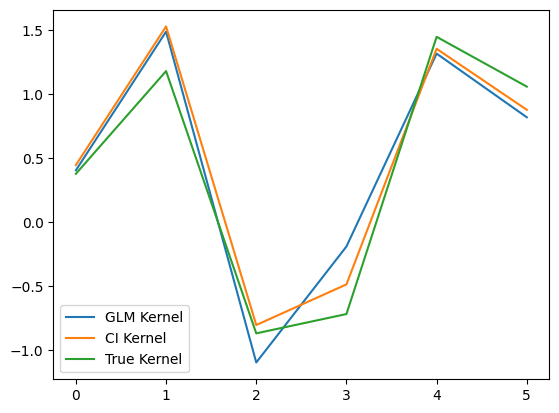

In [8]:
glm_kernel = GLMKernel.extract_single_kernel(data_df=responses_df, feature_id='feature', value_id='value', response_id='response')
ci_kernel = ClassificationImage.extract_single_kernel(data_df=responses_df, feature_id='feature', value_id='value', response_id='response')
plt.plot(GLMKernel.normalize_kernel(glm_kernel), label='GLM Kernel')
plt.plot(GLMKernel.normalize_kernel(ci_kernel), label='CI Kernel')
plt.plot(GLMKernel.normalize_kernel(obs.kernel), label='True Kernel')
plt.legend()



In [9]:
observer_params = {'kernel':['random'],
                   'internal_noise_std':np.arange(0,6.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [100]}
analyser_params = {'kernel_extractor':[ClassificationImage, GLMKernel]}        
                   
sim = Sim(SimpleExperiment, experiment_params, 
          LinearObserver, observer_params, 
          KernelDistance, analyser_params)
sim_df = sim.run_all(n_runs=10)

100%|██████████| 1220/1220 [00:05<00:00, 205.94it/s]


In [27]:
sim_df

,config,n_trials,trial_type,n_features,external_noise_std,kernel,internal_noise_std,criteria,kernel_extractor,run,corr
0,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,7,0.989799
1,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,9,0.996254
2,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,6,0.996972
3,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,3,0.993503
4,0,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,0.0,0,<class 'palin.kernels.classification_images.Cl...,5,0.998589
...,...,...,...,...,...,...,...,...,...,...,...
1215,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,2,0.989934
1216,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,7,0.987563
1217,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,6,0.992239
1218,121,1000,<class 'palin.simulation.trial.Int2Trial'>,5,100,random,6.0,0,<class 'palin.kernels.glm_kernel.GLMKernel'>,9,0.985724


<AxesSubplot: xlabel='internal_noise_std', ylabel='corr'>

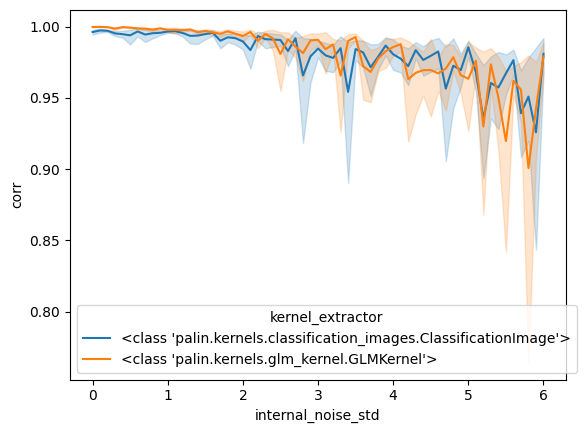

In [14]:
sns.lineplot(data=sim_df,
             x='internal_noise_std',
             y='corr',
             hue='kernel_extractor')

## Test GLMMethod

In [11]:
exp = SimpleExperiment(n_trials = 500,
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = 3, 
                                        criteria = 0)
responses = obs.respond_to_experiment(exp)
responses_df = Analyser.to_df(exp, responses)

In [20]:
norm_ci_value = GLMMethod.extract_norm_ci_value(data_df=responses_df)
norm_ci_value

12.574688648860807

In [21]:
model = GLMMethod.build_model()
model

100%|██████████| 490/490 [00:03<00:00, 123.49it/s]


In [23]:
estimated_noise_CI = norm_ci_value * model.params[1] + model.params[0]
estimated_noise_CI

2.225598361014603

In [ ]:
GLMMethod.extract_single_internal_noise(responses_df, kernel_extractor=GLMKernel)

100%|██████████| 490/490 [00:05<00:00, 90.40it/s] 


2.2990789511549043

## Compare CI with IN double_pass

In [28]:
internal_noise_std = np.arange(0.3, 5, 0.5)
n_trials = np.arange(100, 1000, 100)
random_kernel=[1, 0.8, 0.6, 0.4, 0.2, 0.1, 0.05]
results_fix = []

for n_trial in n_trials:
    exp = DoublePassExperiment(
        n_trials=n_trial,
        n_repeated=n_trial,
        trial_type=Int2Trial,
        n_features=7,
        external_noise_std=100
    )

    for noise in internal_noise_std:
        obs = LinearObserver(kernel=random_kernel,
                                 internal_noise_std=noise, 
                                 criteria=0)
        responses = obs.respond_to_experiment(exp)
        responses_df = Analyser.to_df(exp, responses)

        estimated_noise_CI=GLMMethod.extract_single_internal_noise(responses_df, kernel_extractor=GLMKernel)
        
        ana = InternalNoiseValue(internal_noise_extractor=DoublePass, model_file='model.csv')
        data = ana.analyse(exp, obs, responses)
        metrics = ana.get_metric_names()

        results_fix.append({
            'n_trials': n_trial,
            'internal_noise_std': noise,
            'estimated_noise_CI': estimated_noise_CI,
            metrics[0]: data[0],  
            metrics[1]: data[1]
        })
       
results_df = pd.DataFrame(results_fix)
results_df

100%|██████████| 490/490 [00:04<00:00, 100.95it/s]


,n_trials,internal_noise_std,estimated_noise_CI,estimated_internal_noise,estimated_criteria
0,100,0.3,2.124364,0.2,-2.000000e-01
1,100,0.8,1.594222,1.2,-1.000000e-01
2,100,1.3,1.572188,1.1,2.000000e-01
3,100,1.8,1.850936,0.6,2.000000e-01
4,100,2.3,2.101399,1.5,3.000000e-01
...,...,...,...,...,...
85,900,2.8,2.154651,3.3,-1.776357e-14
86,900,3.3,2.515100,3.4,9.000000e-01
87,900,3.8,2.653806,4.5,7.000000e-01
88,900,4.3,3.048628,3.9,-4.000000e-01


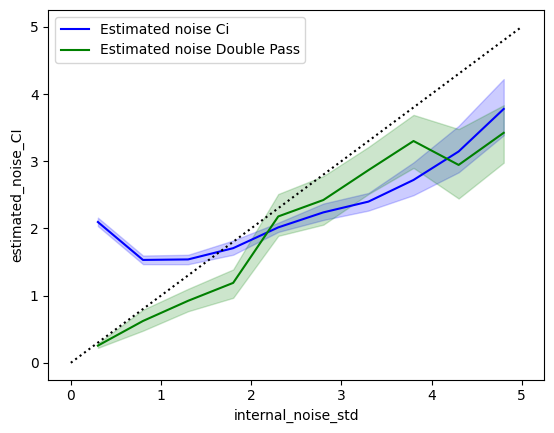

In [37]:
sns.lineplot(data=results_df, x='internal_noise_std', y='estimated_noise_CI', label='Estimated noise Ci', color='blue')
sns.lineplot(data=results_df, x='internal_noise_std', y='estimated_internal_noise', label='Estimated noise Double Pass', color='green')

plt.plot([0,5],[0,5],'k:')

<AxesSubplot: xlabel='internal_noise_std', ylabel='estimated_noise_CI'>

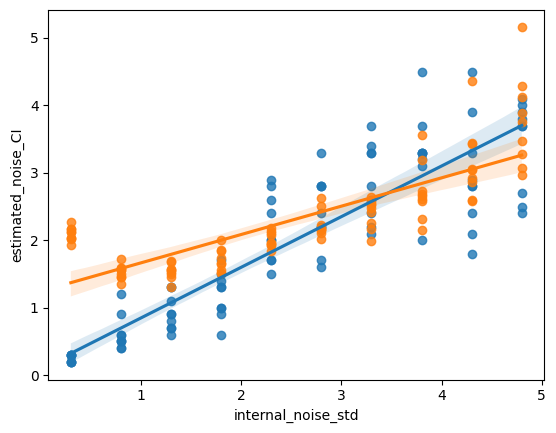

In [47]:
sns.regplot(data=results_df, x="internal_noise_std", y="estimated_internal_noise")
sns.regplot(data=results_df, x="internal_noise_std", y="estimated_noise_CI")


In [32]:
InternalNoiseValue(internal_noise_extractor=GLMMethod, kernel_extractor=GLMKernel).analyse(exp, obs, responses)

100%|██████████| 490/490 [00:04<00:00, 121.92it/s]


(4.195135621977944, None)

In [25]:
InternalNoiseValue(internal_noise_extractor=InterceptMethod, model_file='large_model.csv', kernel_extractor=ClassificationImage).analyse(exp, obs, responses)

ValueError: cannot insert response, already exists

In [ ]:
InterceptMethod.extract_single_internal_noise(responses_df, model_file='large_model.csv', kernel_extractor=ClassificationImage)

ValueError: cannot insert response, already exists

In [348]:
# InterceptMethod.extract_single_internal_noise(responses_df, model_file='large_model.csv', kernel_extractor=ClassificationImage)
# InternalNoiseValue(internal_noise_extractor=InterceptMethod, model_file='large_model.csv', kernel_extractor=ClassificationImage).analyse(exp, obs, responses)

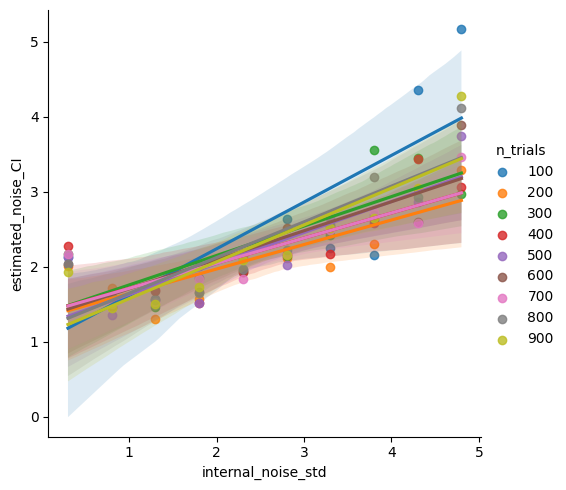

In [36]:
sns.lmplot(
   data=results_df,#[merged_df.n_trials > 200]
   x='internal_noise_std',
   y='estimated_noise_CI',
   hue='n_trials'
   #marker='o',
   #palette='viridis'
)

In [384]:
import statsmodels.formula.api as smf
model1 = smf.ols(formula="internal_noise_std ~ norm_max_feature_ci*n_trials", data=filtered_mean_ci_size_df).fit()
print(model1.params)
filtered_mean_ci_size_df['estimated_noise_CI'] = (filtered_mean_ci_size_df['norm_max_feature_ci'] * model1.params[1] + model1.params[0])

Intercept                      -1.052558
norm_max_feature_ci             0.440062
n_trials                       -0.001573
norm_max_feature_ci:n_trials    0.000159
dtype: float64


In [385]:
filtered_mean_ci_size_df

,internal_noise_std,n_trials,max_feature_ci,norm_max_feature_ci,estimated_internal_noise,estimated_criteria,estimated_noise_CI
0,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
1,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
2,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
3,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
4,0.8,100,0.756076,7.560758,0.5,0.3,2.274643
...,...,...,...,...,...,...,...
562,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766
563,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766
564,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766
565,4.8,900,0.390879,11.726361,4.0,-0.4,4.107766


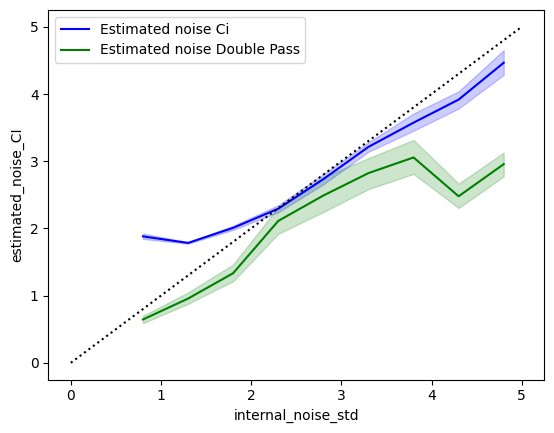

In [386]:
# sns.lineplot(data=filtered_mean_ci_size_df, x='internal_noise_std', y='norm_max_feature_ci', label='norm_max_feature_ci', color='red')
sns.lineplot(data=filtered_mean_ci_size_df, x='internal_noise_std', y='estimated_noise_CI', label='Estimated noise Ci', color='blue')
sns.lineplot(data=filtered_mean_ci_size_df, x='internal_noise_std', y='estimated_internal_noise', label='Estimated noise Double Pass', color='green')

plt.plot([0,5],[0,5],'k:')

## Intercept interval noise

In [85]:
InterceptMethod.compute_prob_agreement(responses_df,
                                       trial_id='trial',
                                       stim_id= 'stim',
                                       feature_id= 'feature',
                                       value_id = 'value',
                                       response_id='response',
                                       kernel_extractor=None)
        

0.7975201158150532

pivot dataframe to have one entry per trial

In [32]:
# group by trial and stim
df = responses_df.groupby(['trial','stim']).agg({'value':list, 'response':'first'}).reset_index()
df.value = df.value.apply(lambda x: np.array(x))
# for each trial, compute trial difference and which stim response
df = df.groupby(['trial']).agg({'value':lambda x:x.diff().iloc[1], #diff produces 2 lines, the first is nan
                           'response': lambda x: 0 if x.iloc[0] else 1}).reset_index()

What we need to compare is the projected difference on the kernel, i.e. if 2 trials are different in dimensions for which the kernel is null, then that difference doesn't matter

Generate all combinations of trials

In [33]:
from itertools import combinations
a, b = map(list, zip(*combinations(df.index, 2)))
comb_df = pd.concat(
    [df.loc[a].add_suffix('_1').reset_index(), df.loc[b].add_suffix('_2').reset_index()], axis=1, 
).drop(columns=['index'])

comb_df['value']=(comb_df.value_1 - comb_df.value_2)
# projected difference on the kernel (if 2 trials are different in dimensions for which the kernel is null, then that difference doesn't matter)
comb_df['proj_value']= comb_df.value.apply(lambda x: np.abs(x.dot(obs.kernel)))
# RMS of trial difference (i.e. trial difference of stim difference)
comb_df.value = comb_df.value.apply(lambda x: np.sqrt(np.sum(x**2)))
comb_df['agree']=(comb_df.response_1==comb_df.response_2).astype(int) 
comb_df = comb_df.drop(columns=['value_1','value_2','response_1','response_2'])

Relation between value & projected value is triangular: when value is small, proj_value can't be high; when value is high, proj_value can be whatever

<Axes: xlabel='value', ylabel='proj_value'>

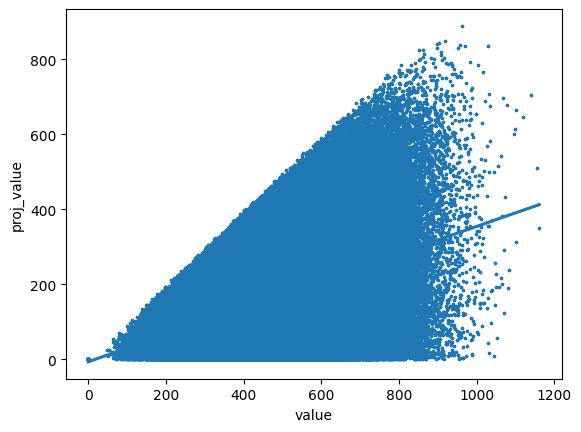

In [27]:
sns.regplot(data=comb_df, x='value',y='proj_value', scatter_kws={'s':2})

fit polynomial


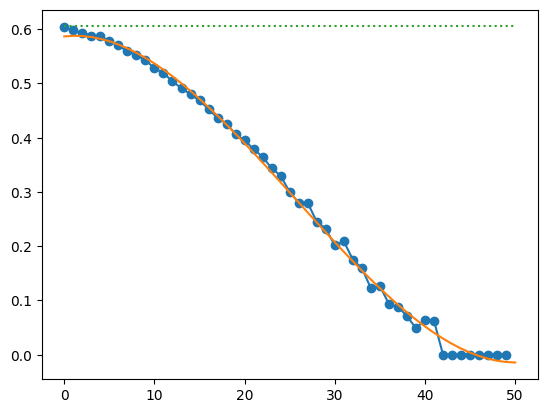

In [34]:
def binned_prob(data=comb_df, value='value',spacing='linear',nbins=100): 
    # get a separate bin for 0 (in case of double_pass)
    min_non_null = data[data[value]>0][value].min()
    if spacing == 'log': 
        bins = pd.cut(data[value],
                  bins=np.logspace(np.log10(min_non_null),
                                   np.log10(data[value].max()+1),nbins),
                  labels=False)
        bins = bins + 1 # increment all bins by 1
        bins = bins.fillna(0) # and give bin 0 to all that are < min_non_null 
    else: 
        bins = pd.cut(data[value],
                  bins=np.linspace(min_non_null,
                                   data[value].max()+1,nbins),
                  labels=False)
    bins = bins + 1 # increment all bins by 1
    bins = bins.fillna(0) # and give bin 0 to all that are < min_non_null 
    return data.groupby(bins).agree.mean().reset_index()
   
bins = binned_prob(comb_df,'proj_value',spacing='linear', nbins=50)
plt.plot(bins.proj_value, bins.agree, 'o-', label='proj linear')

#bins = binned_prob(comb_df,'value',spacing='linear',nbins=50)
#plt.plot(bins.value, bins.agree, 'o-', label='proj log')
#plt.legend()

print('fit polynomial')
try:
    poly = np.poly1d(np.polyfit(bins.proj_value[1:], bins.agree[1:], 3))
    plt.plot(x,poly(x), label='poly')
except RuntimeError: 
    print('fail')


# get p_agree groundtruth

p_agree, p_int1 = DoublePassStatistics().analyse(exp, obs, responses)
plt.plot([0,50],[p_agree,p_agree], ':')


In [29]:
from scipy.optimize import curve_fit
from scipy import stats

plt.plot(bins.proj_value, bins.agree, 'o', label='data')
x = np.linspace(0, 50, 50)

#popt, pcov = curve_fit(sigmoid, bins.proj_value, bins.agree, p0=[10,1])

#x = np.linspace(0, 50, 50)
#y = sigmoid(x, *popt)

#plt.plot(x,y, label='sigmoid')

print('fit exponential')
try: 
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c
    popt, pcov = curve_fit(func, bins.proj_value[1:], bins.agree[1:])
    plt.plot(x,func(x, *popt), label='exp')
except RuntimeError: 
    print('fail')

print('fit polynomial')
try:
    poly = np.poly1d(np.polyfit(bins.proj_value[1:], bins.agree[1:], 3))
    plt.plot(x,poly(x), label='poly')
except RuntimeError: 
    print('fail')

print('fit logistics')
try:
    def sigmoid(x, L ,x0, k, b):
        return L / (1 + np.exp(-k*(x-x0))) + b
    popt, pcov = curve_fit(sigmoid, bins.proj_value[1:], bins.agree[1:])
    plt.plot(x,sigmoid(x, *popt), label='sigmoid')
except RuntimeError: 
    print('fail')
plt.legend()

p_agree, p_int1 = DoublePassStatistics().analyse(exp, obs, responses)
plt.plot([0,50],[p_agree,p_agree], ':')


AttributeError: 'DataFrame' object has no attribute 'proj_value'

see influence of internal noise

IN: 0.0


C:\Users\Aucouturier\AppData\Local\Temp\ipykernel_18640\3851057835.py:39: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,10,index+1)


IN: 0.6
IN: 1.1
IN: 1.7
IN: 2.2
IN: 2.8
IN: 3.3
IN: 3.9
IN: 4.4
IN: 5.0


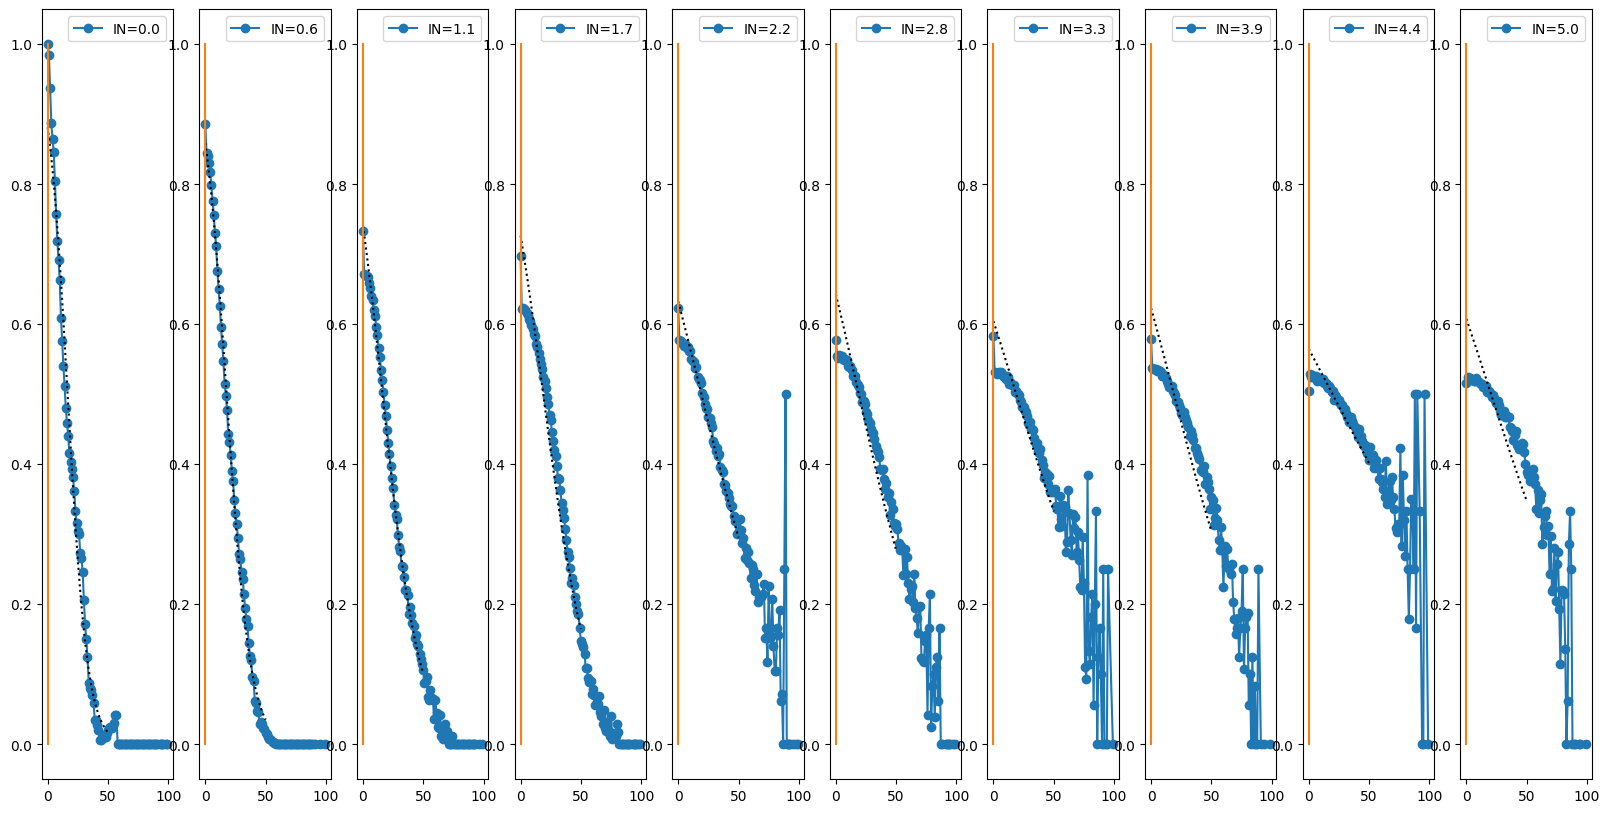

In [344]:
INs = np.linspace(0,5,10)

plt.subplots(figsize=(20,10))

exp = DoublePassExperiment(n_trials = 1000,n_repeated=1000, 
                       trial_type = Int2Trial, 
                       n_features = 6, 
                       external_noise_std = 100)    
    
for index, internal_noise in enumerate(INs):
    
    print('IN: %.1f'%internal_noise)
    # simulate responses
    obs = LinearObserver.with_random_kernel(n_features = exp.n_features,
                                        internal_noise_std = internal_noise, 
                                        criteria = 0)
    responses = obs.respond_to_experiment(exp)
    responses_df = Analyser.to_df(exp, responses)
    
    # group by trial and stim
    df = responses_df.groupby(['trial','stim']).agg({'value':list, 'response':'first'}).reset_index()
    df.value = df.value.apply(lambda x: np.array(x))
    # for each trial, compute trial difference and which stim response
    df = df.groupby(['trial']).agg({'value':lambda x:x.diff().iloc[1], #diff produces 2 lines, the first is nan
                           'response': lambda x: 0 if x.iloc[0] else 1}).reset_index()
    
    from itertools import combinations
    a, b = map(list, zip(*combinations(df.index, 2)))
    comb_df = pd.concat(
        [df.loc[a].add_suffix('_1').reset_index(), df.loc[b].add_suffix('_2').reset_index()], axis=1, 
    ).drop(columns=['index'])

    comb_df['value']=(comb_df.value_1 - comb_df.value_2)
    comb_df['proj_value']= comb_df.value.apply(lambda x: np.abs(x.dot(obs.kernel)))
    comb_df['agree']=(comb_df.response_1==comb_df.response_2).astype(int) 
    comb_df = comb_df.drop(columns=['value_1','value_2','response_1','response_2'])
    
    bins = binned_prob(comb_df,'proj_value',50)
    plt.subplot(1,10,index+1)
    plt.plot(bins.proj_value, bins.agree, 'o-', label='IN=%.1f'%internal_noise)
    
    def func(x, a, b, c):
        return a * np.exp(-b * x) + c

    popt, pcov = curve_fit(sigmoid, bins.proj_value, bins.agree)
    x = np.linspace(0, 50, 50)
    y = sigmoid(x, *popt)
    plt.plot(x,y, 'k:')
    plt.legend()
    plt.plot([0,0],[0,1])


## Simulate with internal noise

Single run

In [ ]:
# single run: 
exp = DoublePassExperiment(n_trials = 1000, n_repeated=200,
          trial_type = Int2Trial, 
          n_features = 5, 
          external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = exp.n_features, 
                            internal_noise_std = 1, 
                            criteria = 0)
responses = obs.respond_to_experiment(exp)
ana = InternalNoiseValue(internal_noise_extractor = DoublePass, model_file='model.csv')
data = ana.analyse(exp, obs, responses)
for name, value in zip(ana.get_metric_names(), data): 
    print("%s: %f"%(name, value))

Simulation

In [ ]:
observer_params = {'kernel':['random'],#[[0,0,0,0,0]]
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[200],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [1]}
analyser_params = {'internal_noise_extractor':[DoublePass], 
                   'model_file': ['model.csv'], 
                   'rebuild_model': [False]}
                   #'internal_noise_range':[np.arange(0,5.1,0.1)],
                   #'criteria_range':[np.arange(-5,5,0.1)],
                   #'n_runs':[2]}
                  
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)
sim_df = sim.run_all_single_thread(n_runs=1)



In [ ]:
sns.lineplot(data=sim_df, x='internal_noise_std', y='estimated_internal_noise')
plt.plot([0,5],[0,5],':')

## Experiment with multiprocessing

In [ ]:
observer_params = {'kernel':['random'],#[[0,0,0,0,0]]
                   'internal_noise_std':np.arange(0,5.1,0.1), 
                  'criteria':[0]}
experiment_params = {'n_trials':[1000], 
                     'n_repeated':[200],
                     'trial_type': [Int2Trial],
                     'n_features': [5],
                     'external_noise_std': [1]}
analyser_params = {'internal_noise_extractor':[DoublePass], 
                   'model_file': ['model.csv'], 
                   'rebuild_model': [False]}
                   #'internal_noise_range':[np.arange(0,5.1,0.1)],
                   #'criteria_range':[np.arange(-5,5,0.1)],
                   #'n_runs':[2]}
                  
sim = Sim(DoublePassExperiment, experiment_params, 
          LinearObserver, observer_params, 
          InternalNoiseValue, analyser_params)

sim.run_all_multi_thread(n_runs=1)


 50%|█████     | 1/2 [00:00<00:00,  1.38it/s]

In [ ]:
model = DoublePass.build_model(internal_noise_range=np.arange(0,5,.1),
                               criteria_range=np.arange(-5,5,.5),
                               n_repeated_trials=1000, n_runs=10)

In [ ]:
model.to_csv('model_large.csv')

## Simulate with kernels

Single run

In [ ]:
# single run: 
exp = SimpleExperiment(n_trials = 100,
          trial_type = Int2Trial, 
          n_features = 5, 
          external_noise_std = 100)
obs = LinearObserver.with_random_kernel(n_features = 5, 
                            internal_noise_std = 1, 
                            criteria = 0)
responses = obs.respond_to_experiment(exp)
ka = KernelDistance(LMMExtractor)
ka.analyse(exp, obs, responses)

In [ ]:
# obs = Obs.with_random_kernel(n_features=5, internal_noise_std=0, criteria=0)

observer_params = {'kernel':['random'],
                   'internal_noise_std':[1], 
                  'criteria':[0]}
experiment_params = {'n_trials':[100],#np.arange(1,1000,100),
                     'trial_type': [Int2Trial],
                     'n_features': np.arange(2,10,1),
                     'external_noise_std': [100]}
analyser_params = {'kernel_extractor':[ClassificationImage], 
                  'distance':['CORR']}


sim = Sim(SimpleExperiment, experiment_params, 
          LinearObserver, observer_params, 
          KernelDistance, analyser_params)
sim_df = sim.run_all(n_runs=10)






In [ ]:
sim_df

In [ ]:
sns.lineplot(data=sim_df, 
             x='n_features',
             y='corr')#, hue='n_features')